In [ ]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=iKMgQfawgvRSUPGds-6OF0Pwgc10hor1_0OjEjRbWYM&tc=b3MSn06ToN9WUwYSpHjCVKUjEHxivvNqLMebfTMZ-1U&cc=AvT1hJghAn6IZT_Lyhu00vaB1WpQoblmBMLfxAXA2WQ

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXlY6IC5aRUiCN2afQUV6J0SmdcCky1TFL9XPrJJtyq3E1y-A1FaBTI

Successfully saved authorization token.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

In [ ]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "name": "Sinduri Coastal Dune"
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [126.50927734375, 36.778259202150586],
            [126.51904392242432, 36.77819018681818],
            [126.52881050109863, 36.77812117148577],
            [126.53857707977295, 36.778052156153365],
            [126.54834365844727, 36.77798314082096],
            [126.50927734375, 36.778259202150586]
          ]
        ]
      }
    }
  ]
}


In [ ]:
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

In [ ]:
ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD')
                       .filterBounds(aoi)
                       .filterDate(ee.Date('2020-08-01'), ee.Date('2020-08-31'))
                       .first()
                       .clip(aoi))
ffa_fl = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                       .filterBounds(aoi)
                       .filterDate(ee.Date('2020-08-01'), ee.Date('2020-08-31'))
                       .first()
                       .clip(aoi))

In [ ]:
ffa_db.bandNames().getInfo()

['VV', 'VH', 'angle']

In [ ]:
url = ffa_db.select('VV').getThumbURL({'min': -20, 'max': 0})
disp.Image(url=url, width=800)

In [ ]:
location = aoi.centroid().coordinates().getInfo()[::-1]

# Make an RGB color composite image (VV,VH,VV/VH).
rgb = ee.Image.rgb(ffa_db.select('VV'),
                   ffa_db.select('VH'),
                   ffa_db.select('VV').divide(ffa_db.select('VH')))

# Create the map object.
m = folium.Map(location=location, zoom_start=12)

# Add the S1 rgb composite to the map object.
m.add_ee_layer(rgb, {'min': [-20, -20, 0], 'max': [0, 0, 2]}, 'FFA')

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

In [ ]:
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

In [ ]:
hist = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.fixedHistogram(0, 0.5, 500),aoi_sub).get('VV').getInfo()
mean = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.mean(), aoi_sub).get('VV').getInfo()
variance = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.variance(), aoi_sub).get('VV').getInfo()

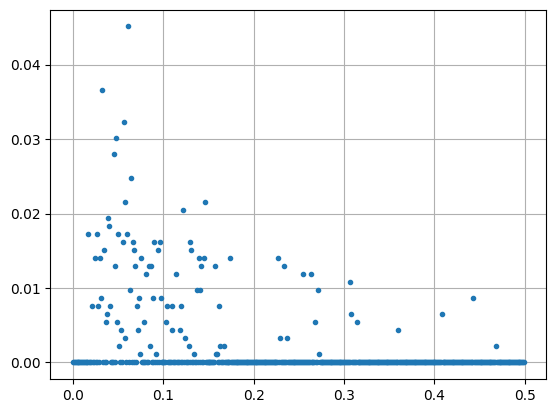

In [ ]:
a = np.array(hist)
x = a[:, 0]                 # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1]) # normalized array of bucket contents
plt.grid()
plt.plot(x, y, '.')
plt.show()

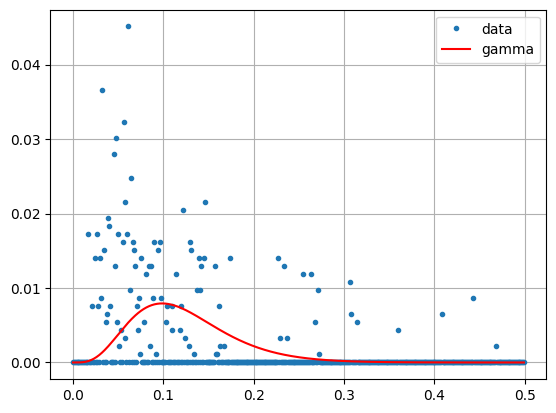

In [ ]:
alpha = 5
beta = mean/alpha
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, gamma.pdf(x, alpha, 0, beta)/1000, '-r', label='gamma')
plt.legend()
plt.show()